In [1]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Some hidden code... to show/hide this cell's raw code input, click (or double click if stubborn!) <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################
from IPython.core.display import HTML
def css_styling():
    styles = open("./ES_ML_SOSSO/colors.css", "r").read()
    return HTML(styles)
css_styling()

# CH413: Computational Workshop 1
## Machine Learning for Drug Discovery

In this workshop, we are going to use a Gaussian process to build a machine learning model for the solubility of a molecular dataset. To this end, we will use some computational tools, most notably...

### Jupyter notebooks

<img src="./ES_ML_SOSSO/jn_logo.png" width="300">

**This!** is actually a Jupyter notebook! It allows you to:

- Write down some text
- Write computer programs using a number of languages: we are going to use Python
- Visualize the outcome of your calculations
- Take advantage of powerful computational tools

All of this in one place! First things first...

<div class=warn>
These blue boxes contain instructions for you to follow, or stuff for you to do
<h2>How to access this Jupyter notebook</h2>

* <b>Step 1</b>: Open a web browser, go to [this page](https://warwick.ac.uk/fac/sci/chemistry/research/maurer/maurergroup/software/iatl_strategic_project/), scroll down, download the Login App (the Windows exacutable if using ITS machines) and double click on the executable (usually ended up into the Download folder) <br>
* <b>Step 2</b>: The Notebook Launcher pops up: select the CH413 module and fill in the boxes using your SCRTP username and password <br>
* <b>Step 3</b>: Open the Jupyter notebook you are interested in, e.g. Workshop_1_Class.ipynb <br>
* <b>Step 4</b>: Make a copy of the orginal notebook (which is read only). In the toolbar on top of the notebook: File - Make a Copy <br>
* <b>Step 5</b>: You're all set! <br><br>
<b> Remember: </b> You can access this notebook at home at any time by going through the same steps on e.g. your laptop - all the changes you have made will be saved and synced! At the moment, though, you'll have to tunnel through the campus network via VPN (see [here](https://warwick.ac.uk/services/its/servicessupport/networkservices/vpn/))<br>
<div/>

## Right... but what - is - a Jupyter notebook exactly?
A Jupyter notebook is a collection of "cells" - blocks within which we can e.g. write down an equation or plot a function. We will use "Markdown cells" to write down text and equations, and "Code cells" to do everything else. Cells can be inserted (and copied, and pasted, and cut!) via the toolbar above. Once we are happy with the content of a given cell, we have to "Run" it - to execute it, by holding the shift key and hitting the enter/return key. The Jupyter notebook will take care of running the cell, and let us know if everything is ok. You can also run a cell, or indeed all the cells in a notebook, via the same toolbar above. Let's have a look at Markdown and Code cells, then...

### This is a Markdown cell
Thus, we can write into it! To edit the cell, a double click of the mouse should do.
We can play around with **bold text**, *italic text*, 
# Big Headings, 
## Small Headings, 
### Tiny Headings,
and much more. Importantly, we can also write down equations using LaTeX syntax. This one should hopefully look quite familiar:

$$
K(\bf{x}_i,\bf{x}_j)=\exp\left ( -\frac{||\bf{x}_i - \bf{x}_j||^2}{L}\right )
$$

Remember, LaTeX may look daunting at the beginning, but it is the best documented markup language in the world, and after a little while it becomes natural. In fact, journal articles and books are ultimately *all* typesetted in LaTeX!

<div class=warn>
Write down the expression of an exponential kernel - in a new Markdown cell. Don't know where to start? Google it!
<div/>

In [1]:
string = "This is a Code cell"
print(string) 

This is a Code cell


### Wait, what happened?
In the cell above, we actually used some Python already! We did two things:

- 1. We have stored some text (**This is a code cell**) into a *variable* we have called **string**
- 2. We have printed the variable **string**

## P is for Python!
What's Python anyway? It's a programming language - one of many, such as C++ or Fortran. It is especially popular these days, mostly because there exist a phenomenal amount of Python libraries (or packages, or modules...) out there that can be harnessed for free. These can in turn be used to do all sort of interesting things, from machine learning for drug design to stock market analysis. This is the reason why a decent knowledge of Python is now often indicated as a desirable (transferable!) skill when interviewing for jobs in Pharma companies and finance alike.
<img src="./ES_ML_SOSSO/python_logo.png" width="300">
Great - now that we know everything about Python, Jupyter Notebooks, Markdown and Code cells, we have what we need to make a start...

In [2]:
%%capture
from __future__ import division

# This is a comment - the # tells Python to just ignore whatever follows

# First things first, we are going to "take advantage of powerful computational tools"
# Specifically, we are going to "import" a number of libraries - an incredibly useful set of of Pythonic tools
# that will save us a lot of time. off we go...

import pandas as pd
import numpy as np # numpy = numeric python. Useful when dealing with e.g. arrays...
import ES_ML_SOSSO.chemfun as cf
from numpy.linalg import eigvalsh,eigh

from rdkit import Chem # rdkit contains a number of molecular descriptors
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP,MolMR

from sklearn.gaussian_process import GaussianProcessRegressor # sklearn = scikit-learn - which we'll use for our Gaussian process
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

import matplotlib.pyplot as plt # useful to plot data
from sklearn.model_selection import train_test_split
import networkx as nx
from numpy import linalg as LA
% matplotlib inline
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth=1.8

##  The dataset
The dataset we are going to use can be downloaded for free at http://moleculenet.ai/datasets-1. It contains the solubility in $\log[\text{mols/litre}]$ of (1128) common organic small molecules in water.

In [4]:
# We load the dataset into the notebook, specifically into the "data" variable
# using the panda library ("import pandas as pd" above).
# Specifically, we'll use the read_table function, hence...
data=pd.read_table("./ES_ML_SOSSO/dataset.dat",header=None)

In [5]:
# Let's have a look at our dataset
print(data)

                                                      0      1
0     OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)... -0.770
1                                Cc1occc1C(=O)Nc2ccccc2 -3.300
2                                  CC(C)=CCCC(C)=CC(=O) -2.060
3                    c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43 -7.870
4                                               c1ccsc1 -1.330
5                                        c2ccc1scnc1c2  -1.500
6                    Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl -7.320
7                      CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O -5.030
8        ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl -6.290
9      COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C  -4.420
10                                            O=C1CCCN1  1.070
11                                     Clc1ccc2ccccc2c1 -4.140
12                                               CCCC=C -2.680
13                           CCC1(C(=O)NCNC1=O)c2ccccc2 -2.640
14                                       CCCCCCCCCCCCCC

## The SMILES format
Our database contains 1128 lines, one line / molecule. In each line, we have the structure of the molecule (1st column) and its solubility (2nd column). The structure is encoded in the so-called SMILES format (https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), which contains a limited amount of information about the structure - chiefly the identity of the atoms and their connectivity (i.e. which bonds are helding them together). A SMILES structure is thus 2D representation of a molecule - let's have a look...

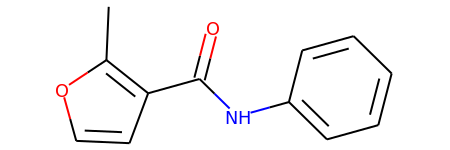

In [6]:
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

# We store the SMILES for each molecules in to the "smiles" (1D) array
# "data[0].values" gets the values of first column ([0], note that in Python we start counting from 0, not 1!) 
# of the (2D) "data" array 
smiles=data[0].values

# Let's do the same with the solubility values - this time, 2nd column, so data[1].values
logS=data[1].values

# Draw the structure from the second [1] SMILES 
test_mol=Chem.MolFromSmiles(smiles[1])

# Visualize the structure
test_mol

<div class=warn>
Add hydrogen atoms to the structure of the last molecule within the dataset and visualize the result
<div/>

In [7]:
# Setting indices to know how data is split 
indices=np.arange(len(smiles))

In [8]:
# Load saved train/test sets
Train=np.load('./ES_ML_SOSSO/Train.npy')
Test=np.load('./ES_ML_SOSSO/Test.npy')
TrainTargets=np.load('./ES_ML_SOSSO/TrainTargets.npy')
TestTargets=np.load('./ES_ML_SOSSO/TestTargets.npy')

In [68]:
len(TestTargets)

226

In [9]:
# Convert into a different format (rdkit internal)
MFSTR=cf.SMILES2MOLES(Train)
MFSTE=cf.SMILES2MOLES(Test)

In [10]:
# Choosing the descriptors for training (SDTR) and test (SDTE) sets. 
from rdkit.Chem import Descriptors

SDTR=[]
for m in MFSTR:
    desc=[]
    desc.append(Chem.Lipinski.NumAromaticRings(m)) # Number of aromatic rings
    desc.append(Chem.Lipinski.NumHAcceptors(m))    # Number of hydrogen bond acceptors
    desc.append(Chem.Lipinski.HeavyAtomCount(m))   # Number of heavy atoms within the molecule
    desc.append(Descriptors.TPSA(m))               # from J. Med. Chem. 43:3714-7, (2000)
    SDTR.append(desc)

SDTE=[]
for m in MFSTE:
    desc=[]
    desc.append(Chem.Lipinski.NumAromaticRings(m)) 
    desc.append(Chem.Lipinski.NumHAcceptors(m))
    desc.append(Chem.Lipinski.HeavyAtomCount(m))
    desc.append(Descriptors.TPSA(m))
    SDTE.append(desc)

<div class=warn>

* Modify the list of descriptors using rdkit built-in descriptors (a list can be found [here](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors))<br>
* Motivate your choice (in a Markdown cell)

<div/>

In [11]:
# Use a Gaussian process (GP) to fit our training set

# Choosing the kernel: radial basis function, initial lengthscale =1
# Note that we are setting boundaries for the lengthscale - to avoid overfitting
# There are obviously better ways to do this...
kernel=RBF(length_scale_bounds=(5e-02,10)) 

# Define our GP
# normalize_y=True -> the mean of the observed target values is set to zero

# To try and avoid finding a local, rather than a global, maximum in the marginal likelihood
# n_restarts_optimizer > 0, which will run the optimization algorithm as many times as specified,
# using randomly-chosen starting coordinates, in the hope that a globally-competitive value can be discovered

# Add some noise to the actual data - useful to improve the numerical accuracy of the fitting

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(SDTR,TrainTargets);

In [12]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(SDTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(SDTE).reshape(-1,1)
# The reshape(-1,1) bit is needed to convert numpy arrays into scikit-learn compatible inputs...

In [13]:
from sklearn.metrics import mean_squared_error

# How are we doing? 
# Let us calculate the mean squared error of our prediction for the training set 
# with respect to the actual solubility values
mse_train=mean_squared_error(TrainTargets,TrainPred)
print("MSE (training)) = ", mse_train)

# Now let's do the same for the test set...
mse_test=mean_squared_error(TestTargets,TestPred)
print("MSE (test)) = ", mse_test)

MSE (training)) =  0.11318504376234893
MSE (test)) =  1.3858676218248343


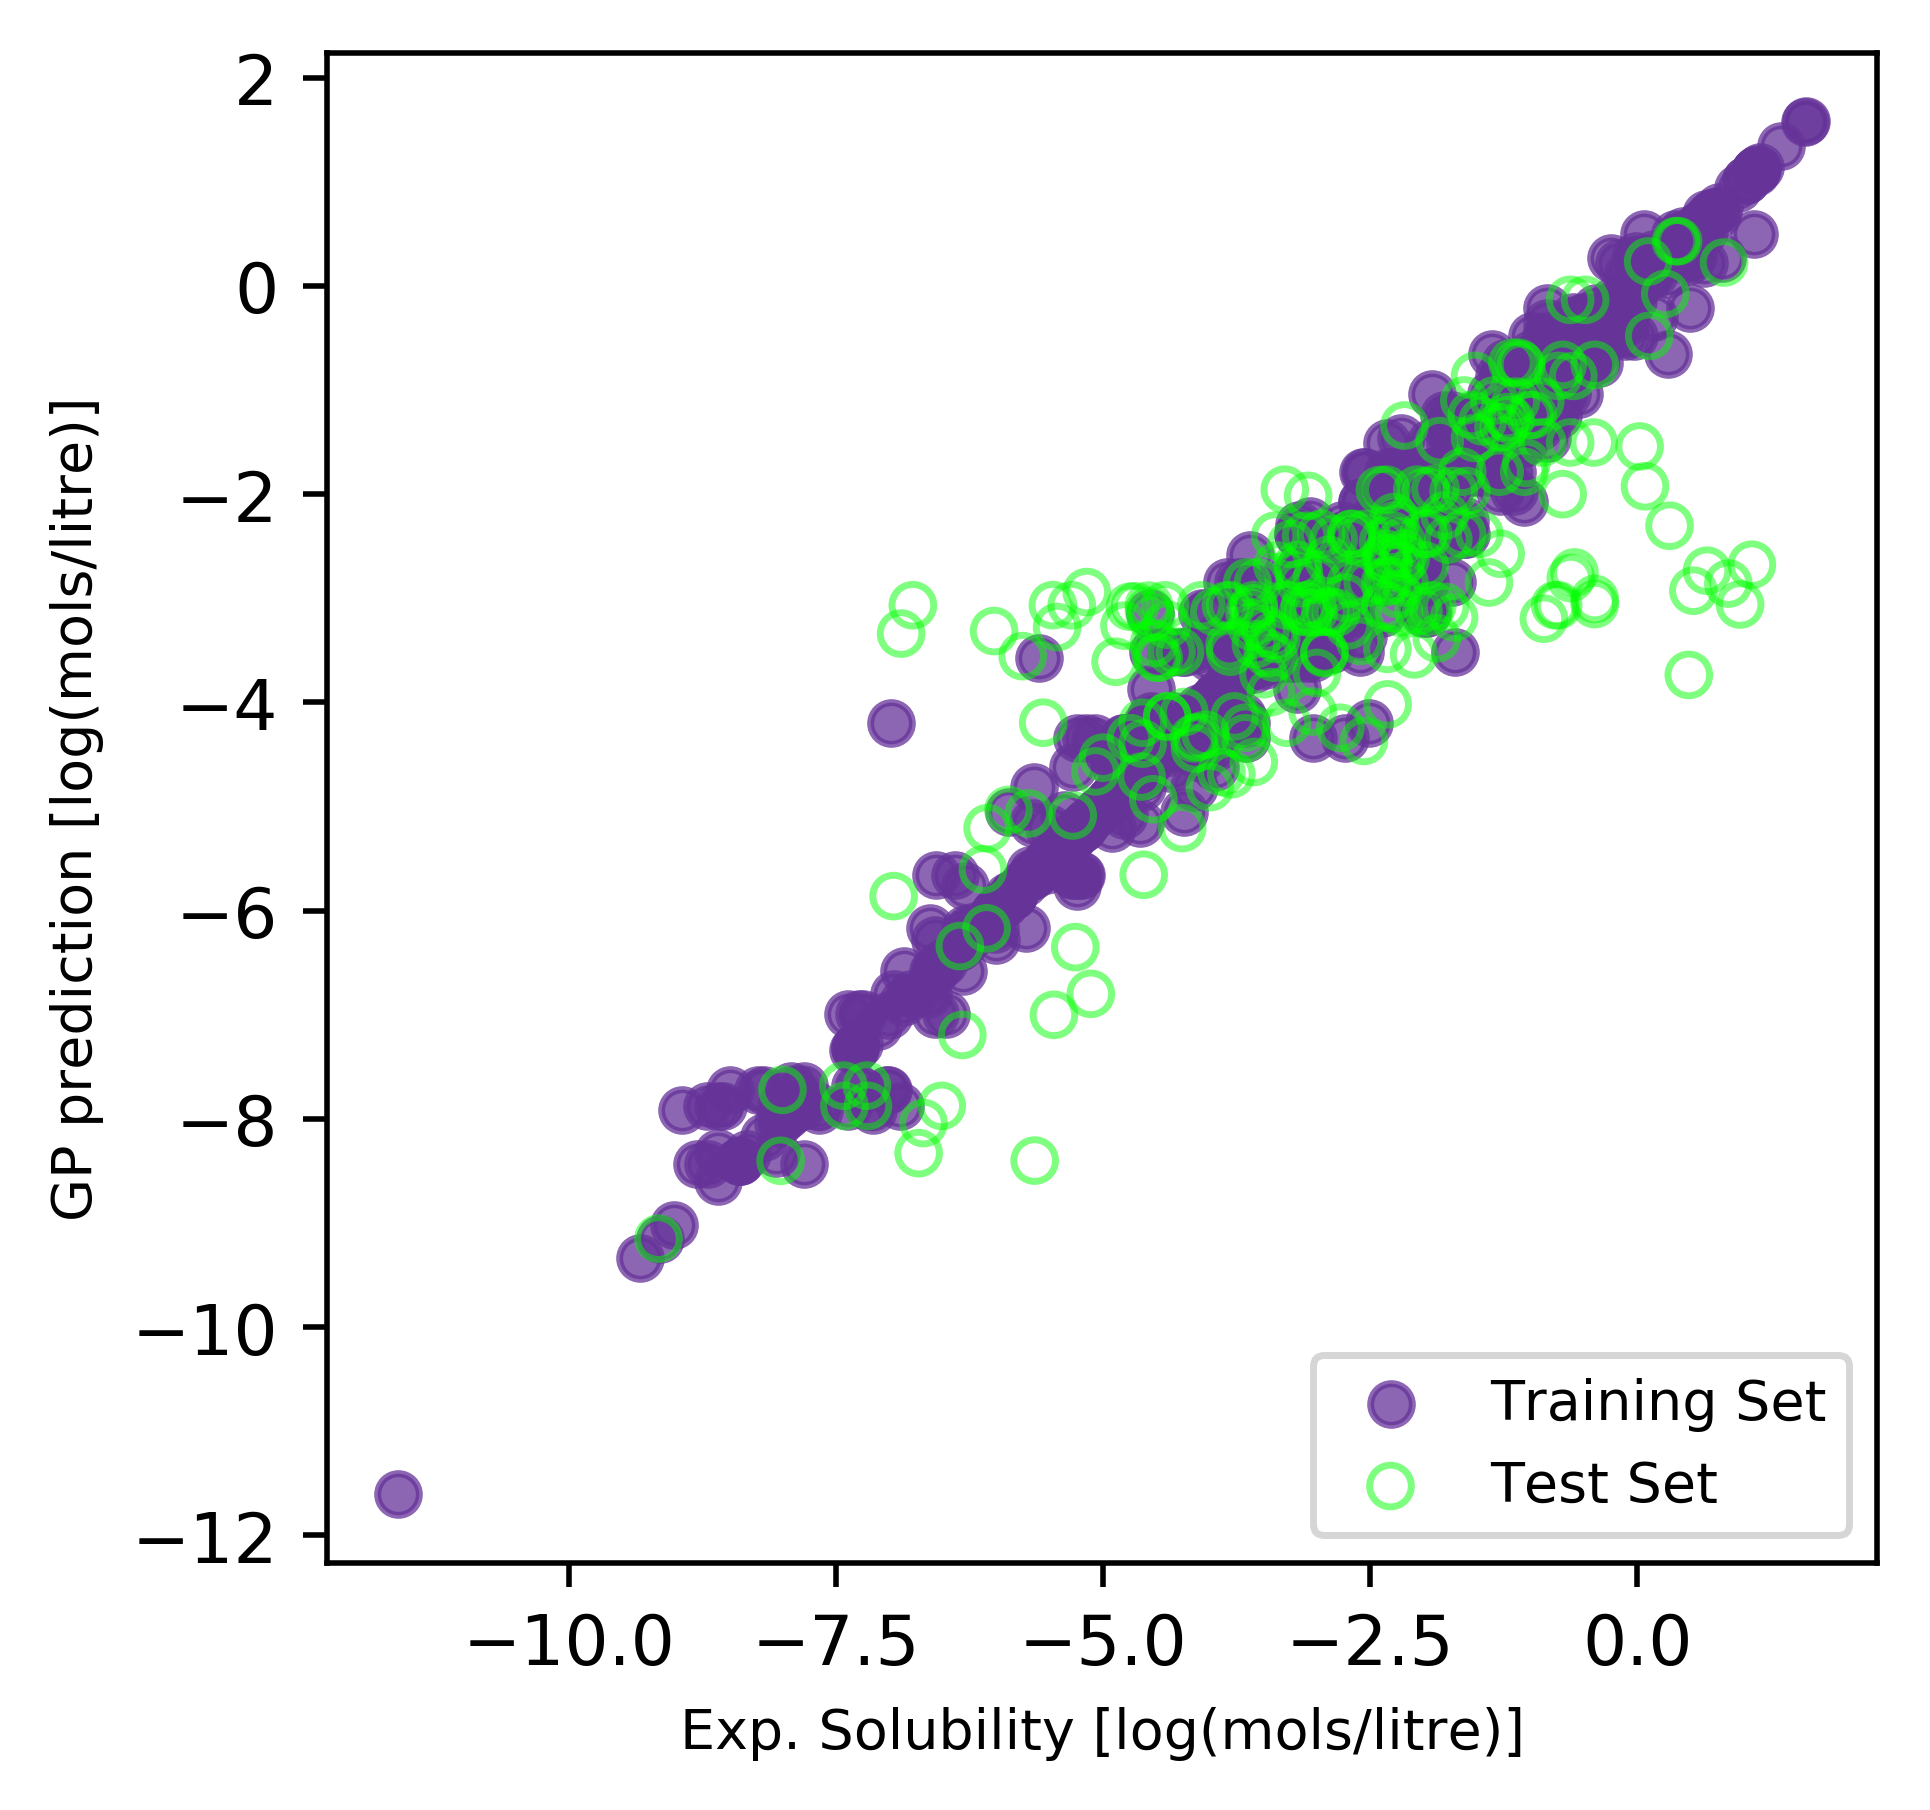

In [14]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Exp. Solubility [log(mols/litre)]',fontsize=8)
plt.ylabel('GP prediction [log(mols/litre)]',fontsize=8)
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);
#plt.savefig('4.png');

<div class=warn>
<h2>Assessed part of the workshop</h2>
    <i>If you don't know it... Google it!</i>
* <b>Step 1</b>: Import the "Lipophilicity" dataset from [http://moleculenet.ai/](http://moleculenet.ai/) <br>
* <b>Step 2</b>: Split the dataset, by (randomly!) assigning 70% of the structure to the trainining set and 30% to the test set.<br>
* <b>Step 3</b>: Plot the probability density function of the target values for both the training and the test dataset <br>
* <b>Step 4</b>: Choose your descriptors: [this paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/cmdc.200700041) can provide a starting point. <br>
* <b>Step 5</b>: Fit a Gaussian Process using a Matérn kernel (setting the initial value of the lengthscale to 1 and the initial value of the hyperparameter $\nu$ to 1.5) in combination with a White kernel (setting the initial value of the noise level to 1) <br>
* <b>Step 6</b>: Visualize the result via a scatter plot (GP prediction vs Exp. Lipophilicity) including training and test sets predictions.<br>
* <b>Step 7</b>: Optimize the value of $\nu$ according to the mean squared error of the predictions for the dataset<br>
* <b>Step 8</b>: Visualize the (hopefully improved) result via a scatter plot (GP prediction vs Exp. Lipophilicity) including training and test sets predictions.<br>    
<div/>

In [15]:
import time

In [16]:
nu=1.4
kernel=Matern(nu=nu, length_scale=1.0, length_scale_bounds=(0.5,10)) 
gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=4,alpha=1e-5,random_state=1);

s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

# # nu=1.5
# # kernel=Matern(nu=nu, length_scale_bounds=(0.5,10)) 
# # gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# s=(float(time.time()))
# gp.fit(SDTR,TrainTargets);
# f=(float(time.time()))
# print(f-s)

KeyboardInterrupt: 

In [47]:
nu=0.5
kernel=Matern(nu=nu, length_scale_bounds=(0.00005,100000)) 
gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

# # nu=1.5
# # kernel=Matern(nu=nu, length_scale_bounds=(0.5,10)) 
# # gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# s=(float(time.time()))
# gp.fit(SDTR,TrainTargets);
# f=(float(time.time()))
# print(f-s)

/home/chem/mssnkt/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: divide by zero encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/home/chem/mssnkt/anaconda3/envs/graphs/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


5.082838296890259


In [28]:
nu=1.5
kernel=Matern(nu=nu, length_scale=1.0, length_scale_bounds=(0.5,10)) 
gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=0,alpha=1e-4,random_state=1);

s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

0.46950697898864746


In [37]:
nu=1.6
kernel=Matern(nu=nu, length_scale=1.0, length_scale_bounds=(0.5,10)) 
gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=0,alpha=1e-4,random_state=1);

s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

KeyboardInterrupt: 

In [ ]:
nu=1.6
kernel=Matern(nu=nu, length_scale=1.0, length_scale_bounds=(0.5,10)) 
gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=0,alpha=1e-4,random_state=1);

s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

In [18]:
# nu=1.51
# kernel=Matern(nu=nu, length_scale_bounds=(0.5,10)) 
# gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# s=(float(time.time()))
# gp.fit(SDTR,TrainTargets);
# f=(float(time.time()))
# print(f-s)

In [39]:
kernel=RBF(length_scale=1.0, length_scale_bounds=(5e-02,10)) 

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

7.576351165771484


In [41]:
kernel=RBF(length_scale=1.5, length_scale_bounds=(5e-02,10)) 

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
s=(float(time.time()))
gp.fit(SDTR,TrainTargets);
f=(float(time.time()))
print(f-s)

7.965511798858643


## HERE

In [8]:
import pandas as pd
import numpy as np

In [18]:
data=pd.read_table("./ES_ML_SOSSO/Lipophilicity.csv",header=None,sep=",") # pandas = databases
data=data.tail(-1) 
tmp=np.array(data) # numpy = matrixes
data_np=tmp[:,[2,1]]
print(data_np)
len(tmp)

[['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14' '3.54']
 ['COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23' '-1.18']
 ['COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl' '3.69']
 ...
 ['COc1cccc2[nH]ncc12' '2.1']
 ['Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3' '2.65']
 ['CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N' '2.7']]


4200

In [70]:
data=pd.read_table("./ES_ML_SOSSO/Lipophilicity.csv",header=None,sep=",")

data=data.tail(-1)
tmp=np.array(data)
data_np=tmp[:,[2,1]]

#data.drop(columns=['exp'])
#data.drop(['e'], 1, inplace=True)
# CMPD_CHEMBLID
#[0, 1]
#data=data.tail(-1)

In [19]:
# Setting indices to know how data is split 
indices=np.arange(len(data_np))

In [71]:
print(data_np)

[['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14' '3.54']
 ['COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23' '-1.18']
 ['COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl' '3.69']
 ...
 ['COc1cccc2[nH]ncc12' '2.1']
 ['Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3' '2.65']
 ['CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N' '2.7']]


In [63]:
#ddd=pd.DataFrame(data_np)
#print(ddd)

                                                      0      1
0               Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1     COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2                COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3     OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4     Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...    3.1
5                  OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4   3.14
6     COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccc...   -.72
7     CNc1cccc(CCOc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...    .34
8                 COc1ccc(cc1)C2=COc3cc(OC)cc(OC)c3C2=O   3.05
9                               Oc1ncnc2scc(c3ccsc3)c12   2.25
10    CS(=O)(=O)c1ccc(Oc2ccc(cc2)C#C[C@]3(O)CN4CCC3C...   1.51
11    C[C@H](Nc1nc(Nc2cc(C)[nH]n2)c(C)nc1C#N)c3ccc(F...   2.61
12                                          O=C1CCCCCN1   -.08
13                     CCCSc1ncccc1C(=O)N2CCCC2c3ccncc3   1.95
14    CC1CCCCC1NC(=O)c2cnn(c2NS(=O)(=O)c3ccc(C)cc3)c...

In [72]:
# Setting indices to know how data is split 
indices=np.arange(len(data_np))

In [22]:
structures=data_np[:,0]
targets=data_np[:,1]
print(targ)

['3.54' '-1.18' '3.69' ... '2.1' '2.65' '2.7']


In [28]:
# # Load saved train/test sets
# Train=np.load('./ES_ML_SOSSO/Train.npy')
# Test=np.load('./ES_ML_SOSSO/Test.npy')
# TrainTargets=np.load('./ES_ML_SOSSO/TrainTargets.npy')
# TestTargets=np.load('./ES_ML_SOSSO/TestTargets.npy')
Train, Test, TrainTargets, TestTargets = train_test_split(structures, targets, test_size=0.2)
print(TrainTargets)

['2.8' '4.3' '2.55' ... '2.33' '2.49' '2.97']


In [26]:
# Convert into a different format (rdkit internal)
MFSTR=cf.SMILES2MOLES(Train)
MFSTE=cf.SMILES2MOLES(Test)

In [85]:
# Choosing the descriptors for training (SDTR) and test (SDTE) sets. 
from rdkit.Chem import Descriptors

SDTR=[]
for m in MFSTR:
    desc=[]
#     desc.append(Chem.Lipinski.NumAromaticRings(m)) # Number of aromatic rings
#     desc.append(Chem.Lipinski.NumHAcceptors(m))    # Number of hydrogen bond acceptors
#     desc.append(Chem.Lipinski.HeavyAtomCount(m))   # Number of heavy atoms within the molecule
    desc.append(Descriptors.TPSA(m))               # from J. Med. Chem. 43:3714-7, (2000)
    SDTR.append(desc)

SDTE=[]
for m in MFSTE:
    desc=[]
#     desc.append(Chem.Lipinski.NumAromaticRings(m)) 
#     desc.append(Chem.Lipinski.NumHAcceptors(m))
#     desc.append(Chem.Lipinski.HeavyAtomCount(m))
    desc.append(Descriptors.TPSA(m))
    SDTE.append(desc)

<div class=warn>

* Modify the list of descriptors using rdkit built-in descriptors (a list can be found [here](http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors))<br>
* Motivate your choice (in a Markdown cell)

<div/>

In [86]:
# Use a Gaussian process (GP) to fit our training set

# Choosing the kernel: radial basis function, initial lengthscale =1
# Note that we are setting boundaries for the lengthscale - to avoid overfitting
# There are obviously better ways to do this...
kernel=RBF(length_scale_bounds=(5e-02,10)) 

# Define our GP
# normalize_y=True -> the mean of the observed target values is set to zero

# To try and avoid finding a local, rather than a global, maximum in the marginal likelihood
# n_restarts_optimizer > 0, which will run the optimization algorithm as many times as specified,
# using randomly-chosen starting coordinates, in the hope that a globally-competitive value can be discovered

# Add some noise to the actual data - useful to improve the numerical accuracy of the fitting

gp=GaussianProcessRegressor(kernel=kernel,normalize_y=True,n_restarts_optimizer=10,alpha=1e-4);

# Fit our GP model
gp.fit(SDTR,TrainTargets);

In [81]:
# Use the trained GP to predict the solubility of our training set...
TrainPred=gp.predict(SDTR).reshape(-1,1)
# ... and of our test set
TestPred=gp.predict(SDTE).reshape(-1,1)
# The reshape(-1,1) bit is needed to convert numpy arrays into scikit-learn compatible inputs...

In [82]:
from sklearn.metrics import mean_squared_error

# How are we doing? 
# Let us calculate the mean squared error of our prediction for the training set 
# with respect to the actual solubility values
mse_train=mean_squared_error(TrainTargets,TrainPred)
print("MSE (training)) = ", mse_train)

# Now let's do the same for the test set...
mse_test=mean_squared_error(TestTargets,TestPred)
print("MSE (test)) = ", mse_test)

MSE (training)) =  0.03337371207725164
MSE (test)) =  1.125588144966604


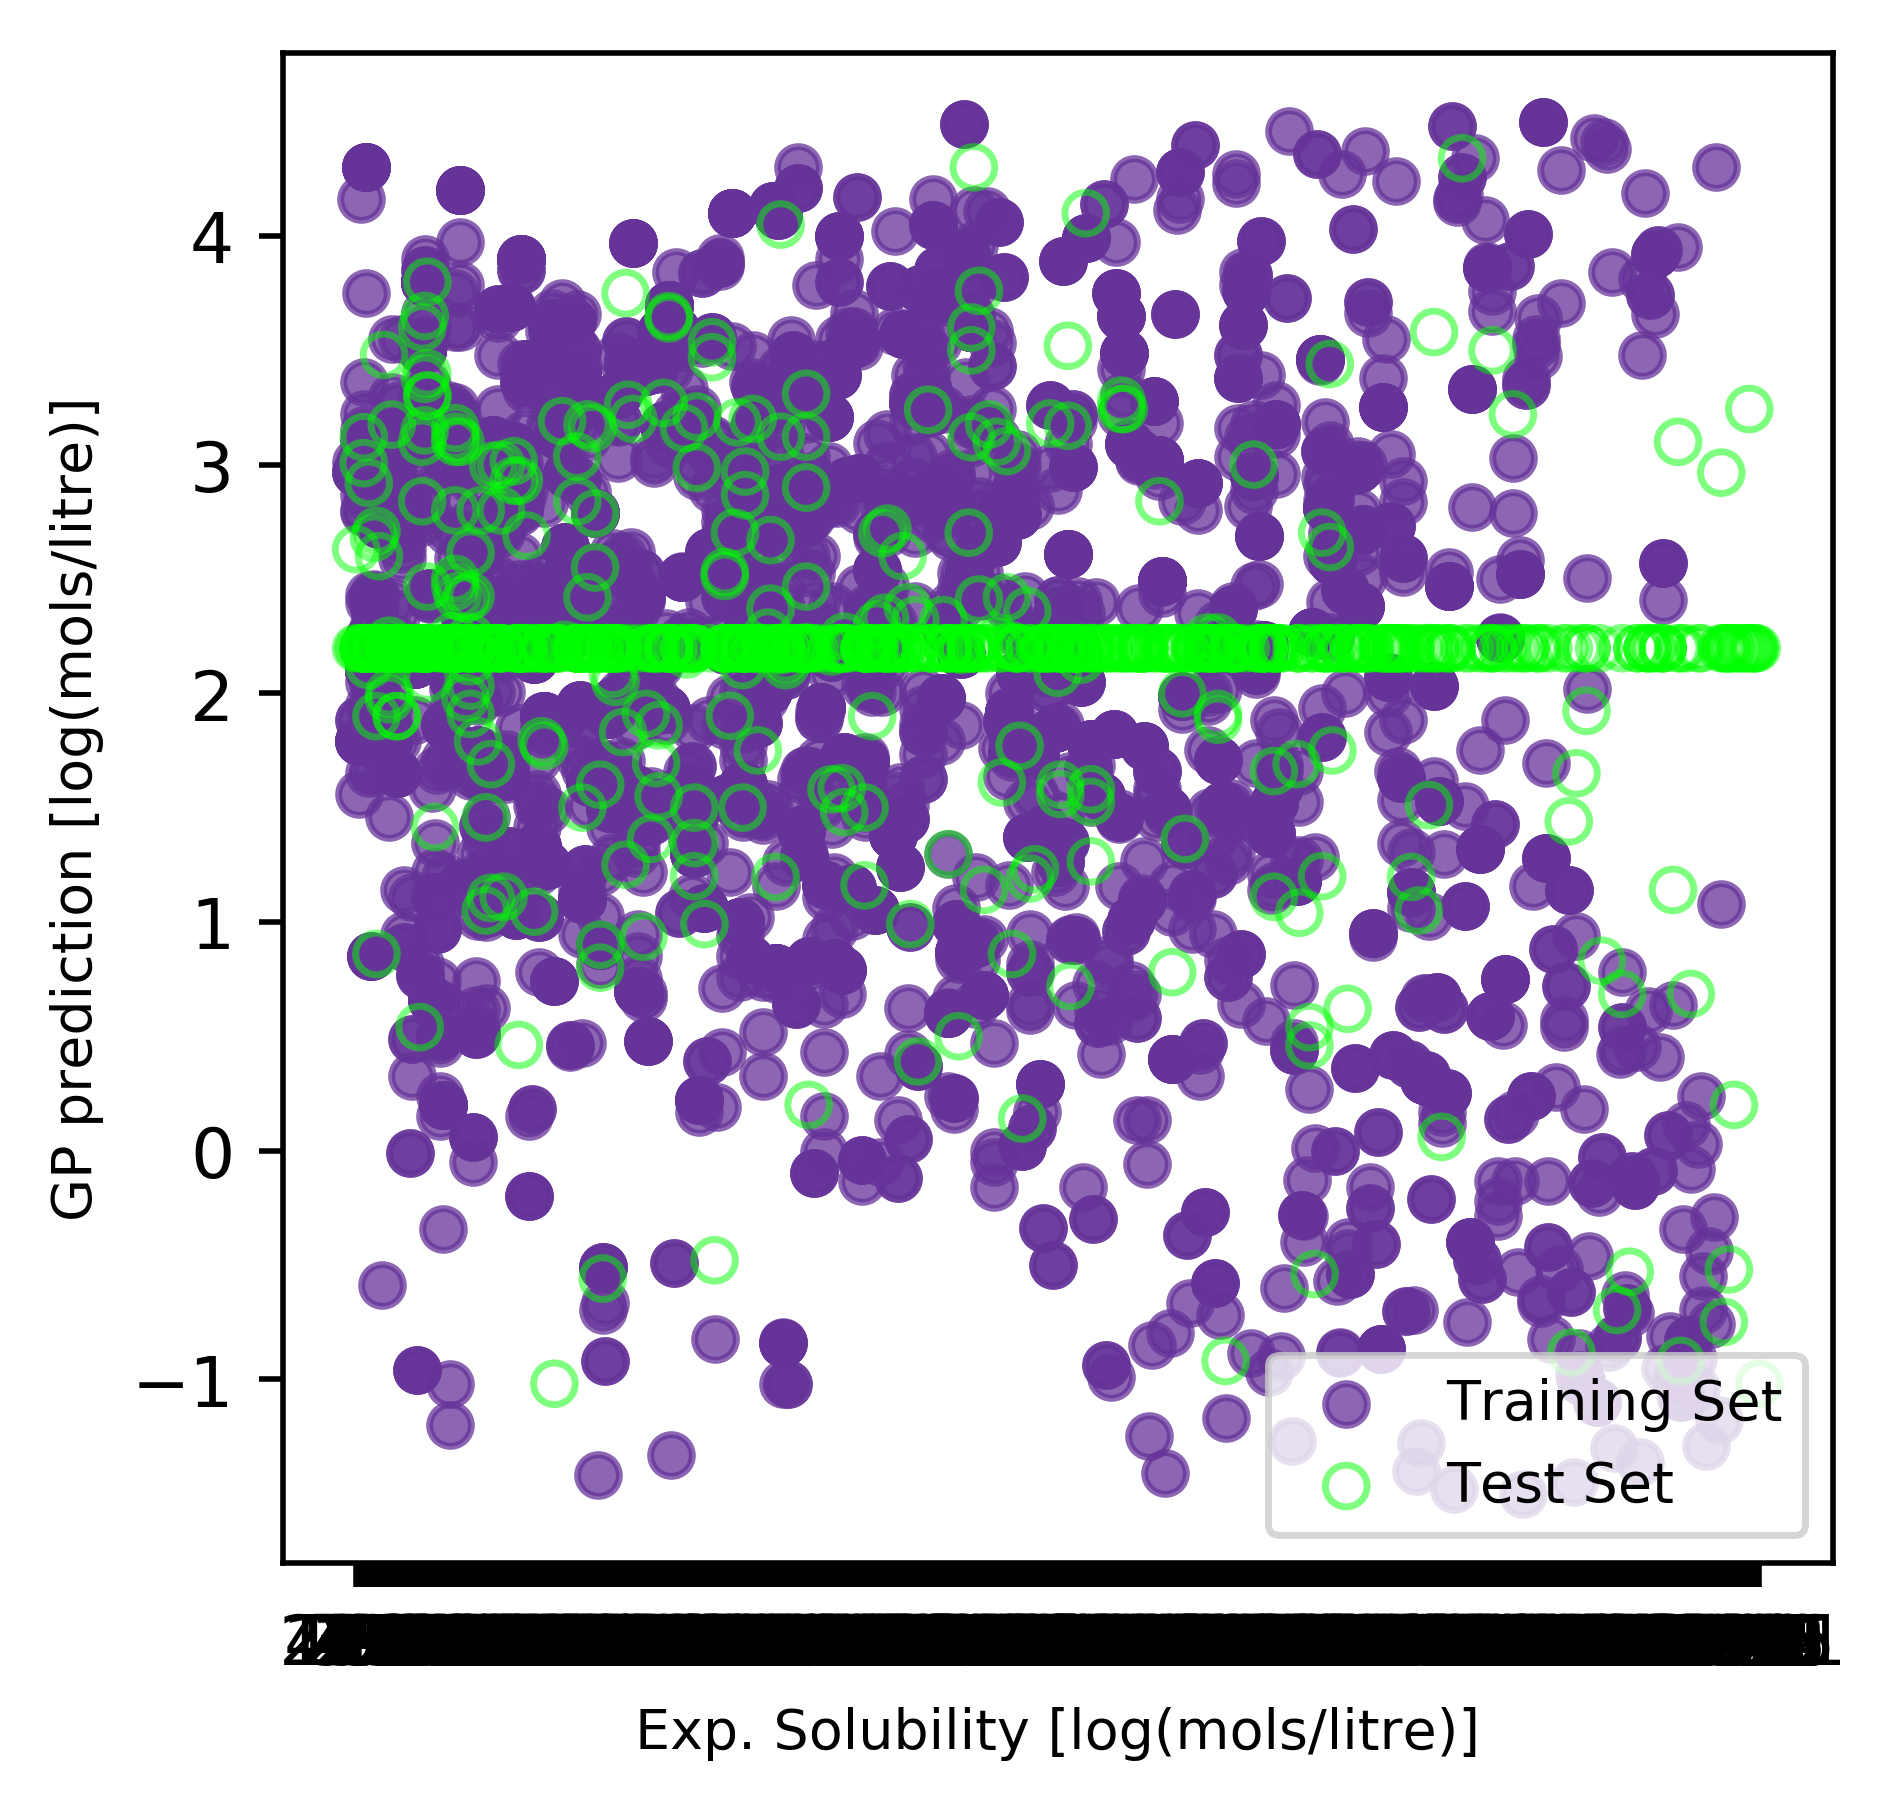

In [83]:
# Let's have a look!
fig=plt.figure(num=None,figsize=(4,4),dpi=500,facecolor='w',edgecolor='k')
plt.xlabel('Exp. Solubility [log(mols/litre)]',fontsize=8)
plt.ylabel('GP prediction [log(mols/litre)]',fontsize=8)
plt.scatter(TrainTargets,TrainPred,color='rebeccapurple',alpha=0.75,label='Training Set')
plt.scatter(TestTargets,TestPred,color='lime',alpha=0.5,label='Test Set',facecolors='none')
plt.legend(fontsize=8,loc=4);
#plt.savefig('4.png');